In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
dataset='bone_tumor'

from loader import DataLoader
dl = DataLoader()
primitive_matrix, ground = dl.load_data(dataset=dataset)

In [3]:
#TODO formalize
train_primitive_matrix = primitive_matrix[0:400,:]
train_ground = ground[0:400]

val_primitive_matrix = primitive_matrix[400:600,:]
val_ground = ground[400:600]

## Synthesize Heuristics

In [4]:
from synthesizer import Synthesizer
syn = Synthesizer(val_primitive_matrix, val_ground)

In [5]:
hf, feat_combos = syn.generate_heuristics(cardinality=3)

#optional pruning
sort_idx = syn.prune_heuristics(hf,feat_combos, keep=5)
hf = [hf[i] for i in sort_idx]
feat_combos = [feat_combos[i] for i in sort_idx]

In [6]:
X_train = train_primitive_matrix[:,feat_combos]
L_train = syn.apply_heuristics(hf,X_train)

X_val = val_primitive_matrix[:,feat_combos]
L_val = syn.apply_heuristics(hf,X_val)

## Verify Heuristics

In [7]:
from verifier import Verifier
vf = Verifier(L_train, L_val, val_ground)

In [8]:
vf.train_gen_model()
vf.gen_model.learned_lf_stats()

Inferred cardinality: 2


,Accuracy,Coverage,Precision,Recall
0,0.911840,0.7838,0.905882,0.708734
1,0.897632,0.7727,0.886703,0.691552
2,0.898031,0.7669,0.898717,0.687871
3,0.905148,0.7770,0.903675,0.704234
4,0.904459,0.7693,0.896962,0.694416


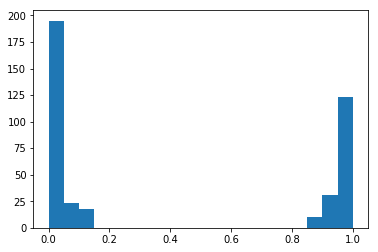

In [9]:
vf.assign_marginals()
plt.hist(vf.train_marginals, bins=20)
plt.show()

In [10]:
vague_idx = vf.find_vague_points(b=0.6, thresh=0.2)
incorrect_idx = vf.find_incorrect_points(b=0.6)
#TODO call the function, print TP/FP/F1/P/R etc in pandas format
1-np.shape(incorrect_idx)[0]/float(np.shape(val_ground)[0])

0.79

## Re-Synthesize Labeling Functions

In [11]:
special_idx = list(set(list(np.concatenate((vague_idx,incorrect_idx)))))

In [12]:
syn = Synthesizer(val_primitive_matrix[special_idx,:], val_ground[special_idx])

In [13]:
hf, feat_combos = syn.generate_heuristics(cardinality=1)

In [14]:
#optional pruning
sort_idx = syn.prune_heuristics(hf,feat_combos, keep=5)
hf = [hf[i] for i in sort_idx]
feat_combos = [feat_combos[i] for i in sort_idx]

In [15]:
X_train = train_primitive_matrix[:,feat_combos]
L_train_new = syn.apply_heuristics(hf,X_train)

X_val = val_primitive_matrix[:,feat_combos]
L_val_new = syn.apply_heuristics(hf,X_val)

In [16]:
L_train_all = np.concatenate((L_train,L_train_new), axis=1)
L_val_all = np.concatenate((L_val,L_val_new), axis=1)

In [17]:
from verifier import Verifier
vf = Verifier(L_train_all, L_val_all, val_ground)

In [18]:
vf.train_gen_model()
vf.gen_model.learned_lf_stats()

Inferred cardinality: 2


,Accuracy,Coverage,Precision,Recall
0,0.905525,0.7801,0.895895,0.704282
1,0.898488,0.7674,0.886987,0.688673
2,0.913824,0.7856,0.898731,0.716937
3,0.893799,0.7580,0.880000,0.672854
4,0.881610,0.7526,0.871730,0.653660
5,0.644559,0.6800,0.620155,0.438726
6,0.697256,0.6887,0.673445,0.481966
7,0.691812,0.6827,0.668364,0.470576
8,0.701636,0.6844,0.678424,0.486817
9,0.732081,0.6920,0.716919,0.508543


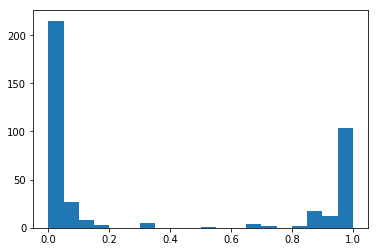

In [19]:
vf.assign_marginals()
plt.hist(vf.train_marginals, bins=20)
plt.show()

In [20]:
vague_idx = vf.find_vague_points(b=0.6, thresh=0.2)
incorrect_idx = vf.find_incorrect_points(b=0.6)
#TODO call the function, print TP/FP/F1/P/R etc in pandas format
1-np.shape(incorrect_idx)[0]/float(np.shape(val_ground)[0])

0.79

In [21]:
special_idx = list(set(list(np.concatenate((vague_idx,incorrect_idx)))))

In [22]:
syn = Synthesizer(val_primitive_matrix[special_idx,:], val_ground[special_idx])
hf, feat_combos = syn.generate_heuristics(cardinality=1)

In [23]:
#optional pruning
sort_idx = syn.prune_heuristics(hf,feat_combos, keep=3)
hf = [hf[i] for i in sort_idx]
feat_combos = [feat_combos[i] for i in sort_idx]

In [24]:
X_train = train_primitive_matrix[:,feat_combos]
L_train_new = syn.apply_heuristics(hf,X_train)

X_val = val_primitive_matrix[:,feat_combos]
L_val_new = syn.apply_heuristics(hf,X_val)

In [25]:
L_train_all = np.concatenate((L_train_all,L_train_new), axis=1)
L_val_all = np.concatenate((L_val_all,L_val_new), axis=1)

In [ ]:
from verifier import Verifier
vf = Verifier(L_train_all, L_val_all, val_ground)

vf.train_gen_model()
vf.gen_model.learned_lf_stats()

vf.assign_marginals()
plt.hist(vf.train_marginals, bins=20)
plt.show()

Inferred cardinality: 2


In [ ]:
vague_idx = vf.find_vague_points(b=0.6, thresh=0.2)
incorrect_idx = vf.find_incorrect_points(b=0.6)
#TODO call the function, print TP/FP/F1/P/R etc in pandas format
1-np.shape(incorrect_idx)[0]/float(np.shape(val_ground)[0])